# 初始化

In [3]:
%%time
import sys
sys.path.append("../chemprop")
sys.path.append("../qsprpred")
sys.path.append("../")
import chemprop
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.decomposition import PCA
import datetime
from loguru import logger
import numpy as np
 
from utils.common_tools import StopWatch
 
import os
import time
DATASET_PATH="../dataset"
LOG_PATH="../logs/"
MODEL_PATH="../models/"
RESULT_PATH="../result/"
 
import sys
sys.path.append("../chemprop")
sys.path.append("../qsprpred")
sys.path.append("../")
import pandas as pd
pd.set_option('max_colwidth',1000)
pd.set_option('display.width',1000)
pd.set_option('display.max_columns',500)
# sys.path.append(r'../..')
from pathlib import Path
project_path = Path.cwd().parent
log_path = Path(project_path, "log")
log_time = time.strftime("%Y_%m_%d")
logger.remove()
logger.add(f'logs/chemprop_feature_{log_time}.log', format='{time:YYYY-MM-DD HH:mm:ss} | ' 
                                "{file} | "# 
                               "{process.name} | "  # 进程名
                               "{thread.name} | "  # 进程名
                               '{module}.{function}:{line} - {level} -{message}',level="INFO", enqueue=True,
encoding="utf-8", rotation="12:00"
)
logger.add(sys.stderr, format='{time:YYYY-MM-DD HH:mm:ss} | ' 
                                "{file} | "# 
                               "{process.name} | "  # 进程名
                               "{thread.name} | "  # 进程名
                               '{module}.{function}:{line} - {level} -{message}',level="INFO", enqueue=True
)
train_param="padel"

# from chemprop.utils import create_logger, makedirs, timeit
# logger = create_logger(name="chemprop2023", save_dir="./logs", quiet=True)
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
def plot_parity(y_true, y_pred, y_pred_unc=None):
    
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2=r2_score(y_true, y_pred)
    plt.plot([axmin, axmax], [axmin, axmax], '--k')
    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1)
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    ax = plt.gca()
    ax.set_aspect('equal')
    at = AnchoredText(
    f"R2 = {r2:.2f}\nRMSE = {rmse:.2f}\nMAE = {mae:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
    logger.info("dataset size:%s"%len(y_true))
    logger.info(f"r2 = {r2:.2f} rmse = {rmse:.2f} mae = {mae:.2f}")
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    metrics_list=[r2,rmse,mae]
    ax.add_artist(at)
    plt.xlabel('True')
    plt.ylabel('Chemprop Predicted')
    plt.show()
    return metrics_list

def train(dataset_file,data_name,target_column,smiles_column,batch_size=50,epochs=50):
    arguments = [
      '--data_path',dataset_file,
      '--dataset_type', 'regression',
      '--save_dir', "result/"+data_name,
      '--target_columns', target_column,
      '--smiles_column',smiles_column,
      '--loss_function','mse',
     # '--checkpoint_dir','ck_dir',
      '--split_type', 'random', # Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    #   '--split_sizes',[1,0,0],
    #   '--split_sizes', '0.8', '0.1', '0.1',
      # '--separate_test_path',DATASET_PATH+"cl/"+"pk_cl_40_test_2023_v1.csv",
      '--num_folds','5',
      '--epochs', '%s'%epochs,
      '--batch_size','%s'%batch_size,
      '--save_smiles_splits',
      '--gpu','1',
      # '--ensemble_size','5',
      '--metric', 'rmse',
      '--empty_cache',
      '--extra_metrics', 'r2', 'mae',
        # '--no_features_scaling',
      '--features_generator','padel',
      '--quiet'
    ]
    
    # split_type: Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    # """Method of splitting the data into train/val/test."""
    # split_sizes: List[float] = None
    # """Split proportions for train/validation/test sets."""
    # split_key_molecule: int = 0
    # """The index of the key molecule used for splitting when multiple molecules are present and constrained split_type is used, like scaffold_balanced or random_with_repeated_smiles.
    #    Note that this index begins with zero for the first molecule."""
    # num_folds: int = 1
    # """Number of folds when performing cross validation."""
    args = chemprop.args.TrainArgs().parse_args(arguments)
    mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)
    logger.info(arguments)
    logger.info("data_name:%s dataset_file:%s target_column:%s"%(data_name,dataset_file,target_column))
    logger.info("mean_score:%s std_score:%s"%(mean_score,std_score))
    train_result="train cross_validate  mean_score:%s std_score:%s"%(mean_score,std_score)
    logger.info(train_result)
    return arguments,train_result
# test_file=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/test_full.csv'
# test_result_fold=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/'
def predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold):
      
    now_time = datetime.datetime.now()
    data_str = now_time.strftime('%Y_%m_%d_%H_%M')
    arguments = [
        '--test_path', test_file,
        '--preds_path', test_result_fold+'test_preds_%s.csv'%data_str,
        '--smiles_column',smiles_column,
        '--checkpoint_dir', "result/"+data_name,
              # '--features_generator','morgan'#'morgan'
        # '--no_features_scaling',
        '--features_generator','padel'
    ]
    # logger.info(arguments)
    args = chemprop.args.PredictArgs().parse_args(arguments)
    preds = chemprop.train.make_predictions(args=args)
    result_path=test_file
    df = pd.read_csv(result_path)
    df['preds'] = [x[0] for x in preds]
    df['Y']=df['preds']
    logger.info(df.head(2))
    result_save_file=test_result_fold+f"{data_name}_pred_result_{data_str}.csv"
    logger.info(result_save_file)
    df.reset_index(inplace=True)
    df = df.drop(columns=df.filter(regex='Unnamed').columns)
    df.to_csv(result_save_file,index=False)
    metrics_list=plot_parity(df[target_column], df.preds)
    return metrics_list,result_save_file

CPU times: user 21.2 ms, sys: 37.3 ms, total: 58.5 ms
Wall time: 72.9 ms


## ensemble and no test

In [1]:
%%time
import sys
sys.path.append("../chemprop")
sys.path.append("../qsprpred")
sys.path.append("../")
import chemprop
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.decomposition import PCA
import datetime
from loguru import logger
import numpy as np
 
from chemprop.utils import StopWatch
 
import os
import time
DATASET_PATH="../dataset"
LOG_PATH="../logs/"
MODEL_PATH="../models/"
RESULT_PATH="../result/"
 
# sys.path.append(r'../..')
from pathlib import Path
project_path = Path.cwd().parent
log_path = Path(project_path, "log")
log_time = time.strftime("%Y_%m_%d")
logger.remove()
logger.add(f'logs/chemprop_feature_{log_time}.log', format='{time:YYYY-MM-DD HH:mm:ss} | ' 
                                "{file} | "# 
                               "{process.name} | "  # 进程名
                               "{thread.name} | "  # 进程名
                               '{module}.{function}:{line} - {level} -{message}',level="INFO", enqueue=True,
encoding="utf-8", rotation="12:00"
)
logger.add(sys.stderr, format='{time:YYYY-MM-DD HH:mm:ss} | ' 
                                "{file} | "# 
                               "{process.name} | "  # 进程名
                               "{thread.name} | "  # 进程名
                               '{module}.{function}:{line} - {level} -{message}',level="INFO", enqueue=True
)
train_param="padel"

# from chemprop.utils import create_logger, makedirs, timeit
# logger = create_logger(name="chemprop2023", save_dir="./logs", quiet=True)
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
def plot_parity(y_true, y_pred, y_pred_unc=None):
    
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2=r2_score(y_true, y_pred)
    plt.plot([axmin, axmax], [axmin, axmax], '--k')
    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1)
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    ax = plt.gca()
    ax.set_aspect('equal')
    at = AnchoredText(
    f"R2 = {r2:.2f}\nRMSE = {rmse:.2f}\nMAE = {mae:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
    logger.info("dataset size:%s"%len(y_true))
    logger.info(f"r2 = {r2:.2f} rmse = {rmse:.2f} mae = {mae:.2f}")
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    metrics_list=[r2,rmse,mae]
    ax.add_artist(at)
    plt.xlabel('True')
    plt.ylabel('Chemprop Predicted')
    plt.show()
    return metrics_list

def train(dataset_file,data_name,target_column,smiles_column,batch_size=50,epochs=50):
    arguments = [
      '--data_path',dataset_file,
      '--dataset_type', 'regression',
      '--save_dir', "result/"+data_name,
      '--target_columns', target_column,
      '--smiles_column',smiles_column,
      '--loss_function','mse',
     # '--checkpoint_dir','ck_dir',
      '--split_type', 'random', # Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    #   '--split_sizes',[1,0,0],
    #   '--split_sizes', '0.8', '0.1', '0.1',
      # '--separate_test_path',DATASET_PATH+"cl/"+"pk_cl_40_test_2023_v1.csv",
      '--num_folds','5',
      '--epochs', '%s'%epochs,
      '--batch_size','%s'%batch_size,
      '--save_smiles_splits',
      '--gpu','1',
      # '--ensemble_size','5',
      '--metric', 'rmse',
      '--empty_cache',
      '--extra_metrics', 'r2', 'mae',
        # '--no_features_scaling',
      '--features_generator','padel',
      '--quiet'
    ]
    
    # split_type: Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    # """Method of splitting the data into train/val/test."""
    # split_sizes: List[float] = None
    # """Split proportions for train/validation/test sets."""
    # split_key_molecule: int = 0
    # """The index of the key molecule used for splitting when multiple molecules are present and constrained split_type is used, like scaffold_balanced or random_with_repeated_smiles.
    #    Note that this index begins with zero for the first molecule."""
    # num_folds: int = 1
    # """Number of folds when performing cross validation."""
    args = chemprop.args.TrainArgs().parse_args(arguments)
    mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)
    logger.info(arguments)
    logger.info("data_name:%s dataset_file:%s target_column:%s"%(data_name,dataset_file,target_column))
    logger.info("mean_score:%s std_score:%s"%(mean_score,std_score))
    train_result="train cross_validate  mean_score:%s std_score:%s"%(mean_score,std_score)
    logger.info(train_result)
    return arguments,train_result
# test_file=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/test_full.csv'
# test_result_fold=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/'
def predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold):
      
    now_time = datetime.datetime.now()
    data_str = now_time.strftime('%Y_%m_%d_%H_%M')
    arguments = [
        '--test_path', test_file,
        '--preds_path', test_result_fold+'test_preds_%s.csv'%data_str,
        '--smiles_column',smiles_column,
        '--checkpoint_dir', "result/"+data_name,
              # '--features_generator','morgan'#'morgan'
        # '--no_features_scaling',
        '--features_generator','padel'
    ]
    # logger.info(arguments)
    args = chemprop.args.PredictArgs().parse_args(arguments)
    preds = chemprop.train.make_predictions(args=args)
    result_path=test_file
    df = pd.read_csv(result_path)
    df['preds'] = [x[0] for x in preds]
    df['Y']=df['preds']
    logger.info(df.head(2))
    result_save_file=test_result_fold+f"{data_name}_pred_result_{data_str}.csv"
    logger.info(result_save_file)
    df.reset_index(inplace=True)
    df = df.drop(columns=df.filter(regex='Unnamed').columns)
    df.to_csv(result_save_file,index=False)
    metrics_list=plot_parity(df[target_column], df.preds)
    return metrics_list,result_save_file
logger.info("初始化完毕")
train_param="padel"

import datetime
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
dataset_dir= DATASET_PATH+"cl/"
 
dataset_name='pk_cl_1215_train_2023_v1.csv'
test_result_fold= '/data/project/pbpk/data/'
dataset_name='pk_cl_40_test_2023_v1.csv'
dataset_file=test_result_fold+'pk_cl_40_test_2023_v1.csv'
# dataset_file=dataset_dir+dataset_name
logger.info(dataset_dir+dataset_name)
smiles_column='SMILES'
target_column= 'human CL (mL/min/kg)_log10'
# target_column= 'human CL (mL/min/kg)_log2'
# target_column= 'Y'
data_name='pk_cl_1215_%s_%s'%(train_param,data_str)
arguments,train_result=train(dataset_file,data_name,target_column,smiles_column,batch_size=32,epochs=10)
test_metrics_list=[]
for i in  range(0, 5, 1):
    test_result_fold=+f'result/{data_name}/fold_%s/'%i
    test_file=test_result_fold+'test_full.csv'
    logger.info(test_file)
    metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
    test_metrics_list.append(metrics_list)
logger.info(test_metrics_list)
df_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
logger.info("5-fold test predict")
logger.info(df_metrics.shape)
logger.info(df_metrics.columns)
# logger.info(df_metrics.head(10))
logger.info(df_metrics.describe())
logger.info("target_column:%s"%target_column)
logger.info("model data_name:%s"%data_name)
logger.info("-------------在40条测试数据上进行测试-------------")
test_metrics_list=[]
test_result_fold= '/data/project/pbpk/data/'
test_file=test_result_fold+'pk_cl_40_test_2023_v1.csv'
logger.info("---test_file:%s---"%test_file)
# data_name='pk_cl_1215_train_2023_log10_64_100_%s_%s'%(train_param,data_str)
# data_name="pk_cl_1215_train_2023_log10_64_100_rdkit_2d_normalized_2023_06_12_15_14"
metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
test_metrics_list.append(metrics_list)

df_test_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
# data=data.T
logger.info(df_test_metrics.shape)
logger.info(df_test_metrics.columns)
metric_name=['r2', 'rmse','mae']

stopwatch.stop('===cl train model: [ %s ]  ==='%data_name)
logger.info("train args:%s,train metrics:%s"%(arguments,train_result))
logger.info("5-fold metrics:%s"%df_metrics.describe())
logger.info("\n[model: %s testset metrics: %s ]"%(data_name,dict(zip(metric_name, metrics_list))))



ImportError: cannot import name 'StopWatch' from 'chemprop.utils' (/Users/wzh/opt/anaconda3/envs/pkmodel/lib/python3.10/site-packages/chemprop/utils.py)

In [ ]:
### padel test

In [ ]:

import sys
sys.path.append("/data/project/pbpk/pk-model/chemprop")
sys.path.append("/data/project/pbpk/pk-model/qsprpred")
sys.path.append("/data/project/pbpk/pk-model")
import chemprop
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.decomposition import PCA
import datetime
from loguru import logger
import os
import time
DATASET_PATH="/data/project/pbpk/pk-model/data/"
LOG_PATH="/data/project/pbpk/pk-model/logs/"
MODEL_PATH="/data/project/pbpk/pk-model/models/"
RESULT_PATH="/data/project/pbpk/pk-model/result/"
BACKUP_PATH="/data/project/pbpk/pk-model/bak/"
# sys.path.append(r'../..')
from pathlib import Path
project_path = Path.cwd().parent
log_path = Path(project_path, "log")
log_time = time.strftime("%Y_%m_%d")
logger.remove()
logger.add(f'logs/chemprop_{log_time}.log', format='{time:YYYY-MM-DD HH:mm:ss} | ' 
                                "{file} | "# 
                               "{process.name} | "  # 进程名
                               "{thread.name} | "  # 进程名
                               '{module}.{function}:{line} - {level} -{message}',level="INFO", enqueue=True,
encoding="utf-8", rotation="12:00"
)
logger.add(sys.stderr, format='{time:YYYY-MM-DD HH:mm:ss} | ' 
                                "{file} | "# 
                               "{process.name} | "  # 进程名
                               "{thread.name} | "  # 进程名
                               '{module}.{function}:{line} - {level} -{message}',level="INFO", enqueue=True
)
# from chemprop.utils import create_logger, makedirs, timeit
# logger = create_logger(name="chemprop2023", save_dir="./logs", quiet=True)
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
def plot_parity(y_true, y_pred, y_pred_unc=None):
    
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2=r2_score(y_true, y_pred)
    
    plt.plot([axmin, axmax], [axmin, axmax], '--k')

    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1)
    
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    
    ax = plt.gca()
    ax.set_aspect('equal')
    
    at = AnchoredText(
    f"R2 = {r2:.2f}\nRMSE = {rmse:.2f}\nMAE = {mae:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
    logger.info("dataset size:%s"%len(y_true))
    logger.info(f"r2 = {r2:.2f} rmse = {rmse:.2f} mae = {mae:.2f}")
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    metrics_list=[r2,rmse,mae]
    ax.add_artist(at)
    
    plt.xlabel('True')
    plt.ylabel('Chemprop Predicted')
    
    plt.show()
    
    return metrics_list

def train(dataset_file,data_name,target_column,smiles_column,batch_size=50,epochs=50):
    arguments = [
      '--data_path',dataset_file,
      '--dataset_type', 'regression',
      '--save_dir', "result/"+data_name,
      '--target_columns', target_column,
      '--smiles_column',smiles_column,
      '--loss_function','mse',
     # '--checkpoint_dir','ck_dir',
      '--split_type', 'cv-no-test', # Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    #   '--split_sizes',[1,0,0],
    #   '--split_sizes', '0.8', '0.1', '0.1',
     '--separate_test_path',DATASET_PATH+"cl/"+"pk_cl_40_test_2023_v1.csv",
      '--num_folds','5',
      '--epochs', '%s'%epochs,
      '--batch_size','%s'%batch_size,
      '--save_smiles_splits',
      '--gpu','1',
      '--ensemble_size','5',
     '--metric', 'rmse',
      '--empty_cache',
      '--extra_metrics', 'r2', 'mae',
        '--no_features_scaling',
        '--features_generator','rdkit_2d_normalized',
        '--quiet'
    ]
    
    # split_type: Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    # """Method of splitting the data into train/val/test."""
    # split_sizes: List[float] = None
    # """Split proportions for train/validation/test sets."""
    # split_key_molecule: int = 0
    # """The index of the key molecule used for splitting when multiple molecules are present and constrained split_type is used, like scaffold_balanced or random_with_repeated_smiles.
    #    Note that this index begins with zero for the first molecule."""
    # num_folds: int = 1
    # """Number of folds when performing cross validation."""

    args = chemprop.args.TrainArgs().parse_args(arguments)
    mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)
    logger.info(arguments)
    logger.info("data_name:%s dataset_file:%s target_column:%s"%(data_name,dataset_file,target_column))
    logger.info("mean_score:%s std_score:%s"%(mean_score,std_score))

# test_file=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/test_full.csv'
# test_result_fold=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/'
def predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold):
      
    now_time = datetime.datetime.now()
    data_str = now_time.strftime('%Y_%m_%d_%H_%M')
    arguments = [
        '--test_path', test_file,
        '--preds_path', test_result_fold+'test_preds_%s.csv'%data_str,
        '--smiles_column',smiles_column,
        '--checkpoint_dir', "result/"+data_name,
              # '--features_generator','morgan'#'morgan'
        '--no_features_scaling',
        '--features_generator','rdkit_2d_normalized'
    ]
    # logger.info(arguments)
    args = chemprop.args.PredictArgs().parse_args(arguments)
    preds = chemprop.train.make_predictions(args=args)
    result_path=test_file
    df = pd.read_csv(result_path)
    df['preds'] = [x[0] for x in preds]
    df['Y']=df['preds']
    logger.info(df.head(2))
    result_save_file=test_result_fold+f"{data_name}_pred_result_{data_str}.csv"
    logger.info(result_save_file)
    df.reset_index(inplace=True)
    df = df.drop(columns=df.filter(regex='Unnamed').columns)
    df.to_csv(result_save_file,index=False)
    metrics_list=plot_parity(df[target_column], df.preds)
    return metrics_list,result_save_file
logger.info("初始化完毕")
train_param="rdkit_2d_normalized"

def train(dataset_file,data_name,target_column,smiles_column,batch_size=50,epochs=50):
    arguments = [
      '--data_path',dataset_file,
      '--dataset_type', 'regression',
      '--save_dir', "result/"+data_name,
      '--target_columns', target_column,
      '--smiles_column',smiles_column,
      '--loss_function','mse',
     # '--checkpoint_dir','ck_dir',
      '--split_type', 'cv-no-test', # Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    #   '--split_sizes',[1,0,0],
    #   '--split_sizes', '0.8', '0.1', '0.1',
     '--separate_test_path',DATASET_PATH+"cl/"+"pk_cl_40_test_2023_v1.csv",
      '--num_folds','5',
      '--epochs', '%s'%epochs,
      '--batch_size','%s'%batch_size,
      '--save_smiles_splits',
      '--gpu','1',
      '--ensemble_size','5',
     '--metric', 'rmse',
      '--empty_cache',
      '--extra_metrics', 'r2', 'mae',
        # '--no_features_scaling',
        '--features_generator','mordred',
        '--quiet'
    ]
    
    # split_type: Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    # """Method of splitting the data into train/val/test."""
    # split_sizes: List[float] = None
    # """Split proportions for train/validation/test sets."""
    # split_key_molecule: int = 0
    # """The index of the key molecule used for splitting when multiple molecules are present and constrained split_type is used, like scaffold_balanced or random_with_repeated_smiles.
    #    Note that this index begins with zero for the first molecule."""
    # num_folds: int = 1
    # """Number of folds when performing cross validation."""

    args = chemprop.args.TrainArgs().parse_args(arguments)
    mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)
    logger.info(arguments)
    logger.info("data_name:%s dataset_file:%s target_column:%s"%(data_name,dataset_file,target_column))
    logger.info("mean_score:%s std_score:%s"%(mean_score,std_score))

# test_file=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/test_full.csv'
# test_result_fold=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/'
def predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold):
      
    now_time = datetime.datetime.now()
    data_str = now_time.strftime('%Y_%m_%d_%H_%M')
    arguments = [
        '--test_path', test_file,
        '--preds_path', test_result_fold+'test_preds_%s.csv'%data_str,
        '--smiles_column',smiles_column,
        '--checkpoint_dir', "result/"+data_name,
              # '--features_generator','morgan'#'morgan'
        # '--no_features_scaling',
        '--features_generator','mordred'
    ]
    # logger.info(arguments)
    args = chemprop.args.PredictArgs().parse_args(arguments)
    preds = chemprop.train.make_predictions(args=args)
    result_path=test_file
    df = pd.read_csv(result_path)
    df['preds'] = [x[0] for x in preds]
    df['Y']=df['preds']
    logger.info(df.head(2))
    result_save_file=test_result_fold+f"{data_name}_pred_result_{data_str}.csv"
    logger.info(result_save_file)
    df.reset_index(inplace=True)
    df = df.drop(columns=df.filter(regex='Unnamed').columns)
    df.to_csv(result_save_file,index=False)
    metrics_list=plot_parity(df[target_column], df.preds)
    return metrics_list,result_save_file
logger.info("初始化完毕")
train_param="mordred"

import datetime
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
dataset_dir= DATASET_PATH+"cl/"
 
dataset_name='pk_cl_1215_train_2023_v1.csv'
dataset_file=dataset_dir+dataset_name
logger.info(dataset_dir+dataset_name)
smiles_column='SMILES'
target_column= 'human CL (mL/min/kg)_log10'
# target_column= 'human CL (mL/min/kg)_log2'
# target_column= 'Y'
data_name='pk_cl_1215_%s_%s'%(train_param,data_str)
arguments,train_result=train(dataset_file,data_name,target_column,smiles_column,batch_size=32,epochs=200)
test_metrics_list=[]
for i in  range(0, 5, 1):
    test_result_fold=+f'result/{data_name}/fold_%s/'%i
    test_file=test_result_fold+'test_full.csv'
    logger.info(test_file)
    metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
    test_metrics_list.append(metrics_list)
logger.info(test_metrics_list)
df_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
logger.info("5-fold test predict")
logger.info(df_metrics.shape)
logger.info(df_metrics.columns)
# logger.info(df_metrics.head(10))
logger.info(df_metrics.describe())
logger.info("target_column:%s"%target_column)
logger.info("model data_name:%s"%data_name)
logger.info("-------------在40条测试数据上进行测试-------------")
test_metrics_list=[]
test_result_fold= '/data/project/pbpk/data/'
test_file=test_result_fold+'pk_cl_40_test_2023_v1.csv'
logger.info("---test_file:%s---"%test_file)
# data_name='pk_cl_1215_train_2023_log10_64_100_%s_%s'%(train_param,data_str)
# data_name="pk_cl_1215_train_2023_log10_64_100_rdkit_2d_normalized_2023_06_12_15_14"
metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
test_metrics_list.append(metrics_list)

df_test_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
# data=data.T
logger.info(df_test_metrics.shape)
logger.info(df_test_metrics.columns)
metric_name=['r2', 'rmse','mae']

stopwatch.stop('===cl train model: [ %s ]  ==='%data_name)
logger.info("train args:%s,train metrics:%s"%(arguments,train_result))
logger.info("5-fold metrics:%s"%df_metrics.describe())
logger.info("\n[model: %s testset metrics: %s ]"%(data_name,dict(zip(metric_name, metrics_list))))



# CL TRAIN 

In [ ]:
%%time
import datetime
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
dataset_dir= DATASET_PATH+"cl/"
 
dataset_name='pk_cl_1215_train_2023_v1.csv'
dataset_file=dataset_dir+dataset_name
logger.info(dataset_dir+dataset_name)
smiles_column='SMILES'
target_column= 'human CL (mL/min/kg)_log10'
# target_column= 'human CL (mL/min/kg)_log2'
# target_column= 'Y'
data_name='pk_cl_1215_%s_%s'%(train_param,data_str)
arguments,train_result=train(dataset_file,data_name,target_column,smiles_column,batch_size=32,epochs=200)
test_metrics_list=[]
for i in  range(0, 5, 1):
    test_result_fold=RESULT_PATH+f'{data_name}/fold_%s/'%i
    test_file=test_result_fold+'test_full.csv'
    logger.info(test_file)
    metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
    test_metrics_list.append(metrics_list)
logger.info(test_metrics_list)
df_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
logger.info("5-fold test predict")
logger.info(df_metrics.shape)
logger.info(df_metrics.columns)
# logger.info(df_metrics.head(10))
logger.info(df_metrics.describe())
logger.info("target_column:%s"%target_column)
logger.info("model data_name:%s"%data_name)
logger.info("-------------在40条测试数据上进行测试-------------")
test_metrics_list=[]
test_result_fold= '/data/project/pbpk/data/'
test_file=test_result_fold+'pk_cl_40_test_2023_v1.csv'
logger.info("---test_file:%s---"%test_file)
# data_name='pk_cl_1215_train_2023_log10_64_100_%s_%s'%(train_param,data_str)
# data_name="pk_cl_1215_train_2023_log10_64_100_rdkit_2d_normalized_2023_06_12_15_14"
metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
test_metrics_list.append(metrics_list)

df_test_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
# data=data.T
logger.info(df_test_metrics.shape)
logger.info(df_test_metrics.columns)
metric_name=['r2', 'rmse','mae']

stopwatch.stop('===cl train model: [ %s ]  ==='%data_name)
logger.info("train args:%s,train metrics:%s"%(arguments,train_result))
logger.info("5-fold metrics:%s"%df_metrics.describe())
logger.info("\n[model: %s testset metrics: %s ]"%(data_name,dict(zip(metric_name, metrics_list))))


2023-07-14 17:07:22 | <timed exec> | MainProcess | MainThread | <timed exec>.<module>:8 - INFO -/data/project/pbpk/pk-model/data/cl/pk_cl_1215_train_2023_v1.csv
1215it [00:00, 161028.83it/s]
 12%|█▏        | 140/1215 [00:15<01:36, 11.17it/s]/data/anaconda3/envs/pkmodel/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 15%|█▍        | 180/1215 [00:19<01:40, 10.34it/s]/data/anaconda3/envs/pkmodel/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 21%|██        | 257/1215 [00:26<01:57,  8.19it/s]/data/anaconda3/envs/pkmodel/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 21%|██        | 257/1215 [00:45<01:57,  8.19it/s]/data/anaconda3/envs/pkmode

##  mordred test

In [3]:
%%time

def train(dataset_file,data_name,target_column,smiles_column,batch_size=50,epochs=50):
    arguments = [
      '--data_path',dataset_file,
      '--dataset_type', 'regression',
      '--save_dir', "result/"+data_name,
      '--target_columns', target_column,
      '--smiles_column',smiles_column,
      '--loss_function','mse',
     # '--checkpoint_dir','ck_dir',
      '--split_type', 'random', # Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    #   '--split_sizes',[1,0,0],
    #   '--split_sizes', '0.8', '0.1', '0.1',
     # '--separate_test_path',DATASET_PATH+"cl/"+"pk_cl_40_test_2023_v1.csv",
      '--num_folds','5',
      '--epochs', '%s'%epochs,
      '--batch_size','%s'%batch_size,
      '--save_smiles_splits',
      '--gpu','1',
      # '--ensemble_size','5',
     '--metric', 'rmse',
      '--empty_cache',
      '--extra_metrics', 'r2', 'mae',
        # '--no_features_scaling',
        '--features_generator','mordred',
        '--quiet'
    ]
    
    # split_type: Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    # """Method of splitting the data into train/val/test."""
    # split_sizes: List[float] = None
    # """Split proportions for train/validation/test sets."""
    # split_key_molecule: int = 0
    # """The index of the key molecule used for splitting when multiple molecules are present and constrained split_type is used, like scaffold_balanced or random_with_repeated_smiles.
    #    Note that this index begins with zero for the first molecule."""
    # num_folds: int = 1
    # """Number of folds when performing cross validation."""

    args = chemprop.args.TrainArgs().parse_args(arguments)
    mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)
    logger.info(arguments)
    logger.info("data_name:%s dataset_file:%s target_column:%s"%(data_name,dataset_file,target_column))
    logger.info("mean_score:%s std_score:%s"%(mean_score,std_score))
    train_result="train cross_validate  mean_score:%s std_score:%s"%(mean_score,std_score)
    logger.info(train_result)
    return arguments,train_result
# test_file=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/test_full.csv'
# test_result_fold=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/'
def predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold):
      
    now_time = datetime.datetime.now()
    data_str = now_time.strftime('%Y_%m_%d_%H_%M')
    arguments = [
        '--test_path', test_file,
        '--preds_path', test_result_fold+'test_preds_%s.csv'%data_str,
        '--smiles_column',smiles_column,
        '--checkpoint_dir', "result/"+data_name,
              # '--features_generator','morgan'#'morgan'
        # '--no_features_scaling',
        '--features_generator','mordred'
    ]
    # logger.info(arguments)
    args = chemprop.args.PredictArgs().parse_args(arguments)
    preds = chemprop.train.make_predictions(args=args)
    result_path=test_file
    df = pd.read_csv(result_path)
    df['preds'] = [x[0] for x in preds]
    df['Y']=df['preds']
    logger.info(df.head(2))
    result_save_file=test_result_fold+f"{data_name}_pred_result_{data_str}.csv"
    logger.info(result_save_file)
    df.reset_index(inplace=True)
    df = df.drop(columns=df.filter(regex='Unnamed').columns)
    df.to_csv(result_save_file,index=False)
    metrics_list=plot_parity(df[target_column], df.preds)
    return metrics_list,result_save_file
logger.info("初始化完毕")
train_param="mordred"

import datetime
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
dataset_dir= DATASET_PATH+"cl/"
 
dataset_name='pk_cl_1215_train_2023_v1.csv'
dataset_file=dataset_dir+dataset_name
logger.info(dataset_dir+dataset_name)
smiles_column='SMILES'
target_column= 'human CL (mL/min/kg)_log10'
# target_column= 'human CL (mL/min/kg)_log2'
# target_column= 'Y'
data_name='pk_cl_1215_%s_%s'%(train_param,data_str)
arguments,train_result=train(dataset_file,data_name,target_column,smiles_column,batch_size=32,epochs=50)
test_metrics_list=[]
for i in  range(0, 5, 1):
    test_result_fold=+f'result/{data_name}/fold_%s/'%i
    test_file=test_result_fold+'test_full.csv'
    logger.info(test_file)
    metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
    test_metrics_list.append(metrics_list)
logger.info(test_metrics_list)
df_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
logger.info("5-fold test predict")
logger.info(df_metrics.shape)
logger.info(df_metrics.columns)
# logger.info(df_metrics.head(10))
logger.info(df_metrics.describe())
logger.info("target_column:%s"%target_column)
logger.info("model data_name:%s"%data_name)
logger.info("-------------在40条测试数据上进行测试-------------")
test_metrics_list=[]
test_result_fold= '/data/project/pbpk/data/'
test_file=test_result_fold+'pk_cl_40_test_2023_v1.csv'
logger.info("---test_file:%s---"%test_file)
# data_name='pk_cl_1215_train_2023_log10_64_100_%s_%s'%(train_param,data_str)
# data_name="pk_cl_1215_train_2023_log10_64_100_rdkit_2d_normalized_2023_06_12_15_14"
metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
test_metrics_list.append(metrics_list)

df_test_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
# data=data.T
logger.info(df_test_metrics.shape)
logger.info(df_test_metrics.columns)
metric_name=['r2', 'rmse','mae']

stopwatch.stop('===cl train model: [ %s ]  ==='%data_name)
logger.info("train args:%s,train metrics:%s"%(arguments,train_result))
logger.info("5-fold metrics:%s"%df_metrics.describe())
logger.info("\n[model: %s testset metrics: %s ]"%(data_name,dict(zip(metric_name, metrics_list))))


2023-07-14 13:49:07 | <timed exec> | MainProcess | MainThread | <timed exec>.<module>:76 - INFO -初始化完毕
2023-07-14 13:49:07 | <timed exec> | MainProcess | MainThread | <timed exec>.<module>:86 - INFO -/data/project/pbpk/pk-model/data/cl/pk_cl_1215_train_2023_v1.csv
1215it [00:00, 159816.83it/s]
 12%|█▏        | 141/1215 [00:15<01:56,  9.24it/s]/data/anaconda3/envs/pkmodel/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 15%|█▍        | 180/1215 [00:19<01:42, 10.08it/s]/data/anaconda3/envs/pkmodel/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 21%|██        | 257/1215 [00:39<02:37,  6.09it/s]/data/anaconda3/envs/pkmodel/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis,

TypeError: bad operand type for unary +: 'str'

In [10]:
def train(dataset_file,data_name,target_column,smiles_column,batch_size=50,epochs=50):
    arguments = [
      '--data_path',dataset_file,
      '--dataset_type', 'regression',
      '--save_dir', "result/"+data_name,
      '--target_columns', target_column,
      '--smiles_column',smiles_column,
      '--loss_function','mse',
     # '--checkpoint_dir','ck_dir',
      '--split_type', 'random', # Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    #   '--split_sizes',[1,0,0],
    #   '--split_sizes', '0.8', '0.1', '0.1',
     # '--separate_test_path',DATASET_PATH+"cl/"+"pk_cl_40_test_2023_v1.csv",
      '--num_folds','5',
      '--epochs', '%s'%epochs,
      '--batch_size','%s'%batch_size,
      '--save_smiles_splits',
      '--gpu','1',
      # '--ensemble_size','5',
     '--metric', 'rmse',
      '--empty_cache',
      '--extra_metrics', 'r2', 'mae',
        # '--no_features_scaling',
        '--features_generator','mordred',
        '--quiet'
    ]
    
    # split_type: Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    # """Method of splitting the data into train/val/test."""
    # split_sizes: List[float] = None
    # """Split proportions for train/validation/test sets."""
    # split_key_molecule: int = 0
    # """The index of the key molecule used for splitting when multiple molecules are present and constrained split_type is used, like scaffold_balanced or random_with_repeated_smiles.
    #    Note that this index begins with zero for the first molecule."""
    # num_folds: int = 1
    # """Number of folds when performing cross validation."""

    args = chemprop.args.TrainArgs().parse_args(arguments)
    mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)
    logger.info(arguments)
    logger.info("data_name:%s dataset_file:%s target_column:%s"%(data_name,dataset_file,target_column))
    logger.info("mean_score:%s std_score:%s"%(mean_score,std_score))

# test_file=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/test_full.csv'
# test_result_fold=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/'
def predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold):
      
    now_time = datetime.datetime.now()
    data_str = now_time.strftime('%Y_%m_%d_%H_%M')
    arguments = [
        '--test_path', test_file,
        '--preds_path', test_result_fold+'test_preds_%s.csv'%data_str,
        '--smiles_column',smiles_column,
        '--checkpoint_dir', "result/"+data_name,
              # '--features_generator','morgan'#'morgan'
        # '--no_features_scaling',
        '--features_generator','mordred'
    ]
    # logger.info(arguments)
    args = chemprop.args.PredictArgs().parse_args(arguments)
    preds = chemprop.train.make_predictions(args=args)
    result_path=test_file
    df = pd.read_csv(result_path)
    df['preds'] = [x[0] for x in preds]
    df['Y']=df['preds']
    logger.info(df.head(2))
    result_save_file=test_result_fold+f"{data_name}_pred_result_{data_str}.csv"
    logger.info(result_save_file)
    df.reset_index(inplace=True)
    df = df.drop(columns=df.filter(regex='Unnamed').columns)
    df.to_csv(result_save_file,index=False)
    metrics_list=plot_parity(df[target_column], df.preds)
    return metrics_list,result_save_file
import datetime
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
dataset_dir= DATASET_PATH+"cl/"
 
dataset_name='pk_cl_1215_train_2023_v1.csv'
dataset_file=dataset_dir+dataset_name
logger.info(dataset_dir+dataset_name)
smiles_column='SMILES'
target_column= 'human CL (mL/min/kg)_log10'
# target_column= 'human CL (mL/min/kg)_log2'
# target_column= 'Y'
data_name='pk_cl_1215_%s_%s'%(train_param,data_str)
arguments,train_result=train(dataset_file,data_name,target_column,smiles_column,batch_size=128,epochs=1)
test_metrics_list=[]
for i in  range(0, 5, 1):
    test_result_fold=+f'result/{data_name}/fold_%s/'%i
    test_file=test_result_fold+'test_full.csv'
    logger.info(test_file)
    metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
    test_metrics_list.append(metrics_list)
logger.info(test_metrics_list)
df_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
logger.info("5-fold test predict")
logger.info(df_metrics.shape)
logger.info(df_metrics.columns)
# logger.info(df_metrics.head(10))
logger.info(df_metrics.describe())
logger.info("target_column:%s"%target_column)
logger.info("model data_name:%s"%data_name)
logger.info("-------------在40条测试数据上进行测试-------------")
test_metrics_list=[]
test_result_fold= '/data/project/pbpk/data/'
test_file=test_result_fold+'pk_cl_40_test_2023_v1.csv'
logger.info("---test_file:%s---"%test_file)
# data_name='pk_cl_1215_train_2023_log10_64_100_%s_%s'%(train_param,data_str)
# data_name="pk_cl_1215_train_2023_log10_64_100_rdkit_2d_normalized_2023_06_12_15_14"
metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
test_metrics_list.append(metrics_list)

df_test_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
# data=data.T
logger.info(df_test_metrics.shape)
logger.info(df_test_metrics.columns)
metric_name=['r2', 'rmse','mae']

stopwatch.stop('===cl train model: [ %s ]  ==='%data_name)
# logger.info("train args:%s,train metrics:%s"%(arguments,train_result))
# logger.info("5-fold metrics:%s"%df_metrics.describe())
logger.info("\n[model: %s testset metrics: %s ]"%(data_name,dict(zip(metric_name, metrics_list))))


2023-07-14 13:25:31 | 2297558865.py | MainProcess | MainThread | 2297558865.<cell line: 81>:81 - INFO -/data/project/pbpk/pk-model/data/cl/pk_cl_1215_train_2023_v1.csv
1215it [00:00, 148120.31it/s]
 12%|█▏        | 140/1215 [00:15<02:11,  8.20it/s]/data/anaconda3/envs/pkmodel/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 14%|█▎        | 167/1215 [00:20<02:53,  6.04it/s]/data/anaconda3/envs/pkmodel/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 21%|██        | 257/1215 [00:38<01:52,  8.50it/s]/data/anaconda3/envs/pkmodel/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/data/anaconda3/envs/pkmodel/lib/python3.10/site-packages/numpy/core/f

TypeError: cannot unpack non-iterable NoneType object

## padel test

In [1]:
%%time
import sys
sys.path.append("/data/project/pbpk/pk-model/chemprop")
sys.path.append("/data/project/pbpk/pk-model/qsprpred")
sys.path.append("/data/project/pbpk/pk-model")
import chemprop
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.decomposition import PCA
import datetime
from loguru import logger
import numpy as np
 
from chemprop.utils import StopWatch
 
import os
import time
DATASET_PATH="/data/project/pbpk/pk-model/data/"
LOG_PATH="/data/project/pbpk/pk-model/logs/"
MODEL_PATH="/data/project/pbpk/pk-model/models/"
RESULT_PATH="/data/project/pbpk/pk-model/result/"
BACKUP_PATH="/data/project/pbpk/pk-model/bak/"
# sys.path.append(r'../..')
from pathlib import Path
project_path = Path.cwd().parent
log_path = Path(project_path, "log")
log_time = time.strftime("%Y_%m_%d")
logger.remove()
logger.add(f'logs/chemprop_feature_{log_time}.log', format='{time:YYYY-MM-DD HH:mm:ss} | ' 
                                "{file} | "# 
                               "{process.name} | "  # 进程名
                               "{thread.name} | "  # 进程名
                               '{module}.{function}:{line} - {level} -{message}',level="INFO", enqueue=True,
encoding="utf-8", rotation="12:00"
)
logger.add(sys.stderr, format='{time:YYYY-MM-DD HH:mm:ss} | ' 
                                "{file} | "# 
                               "{process.name} | "  # 进程名
                               "{thread.name} | "  # 进程名
                               '{module}.{function}:{line} - {level} -{message}',level="INFO", enqueue=True
)
train_param="padel"

# from chemprop.utils import create_logger, makedirs, timeit
# logger = create_logger(name="chemprop2023", save_dir="./logs", quiet=True)
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
def train(dataset_file,data_name,target_column,smiles_column,batch_size=50,epochs=50):
    arguments = [
      '--data_path',dataset_file,
      '--dataset_type', 'regression',
      '--save_dir', "result/"+data_name,
      '--target_columns', target_column,
      '--smiles_column',smiles_column,
      '--loss_function','mse',
     # '--checkpoint_dir','ck_dir',
      '--split_type', 'random', # Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    #   '--split_sizes',[1,0,0],
    #   '--split_sizes', '0.8', '0.1', '0.1',
     # '--separate_test_path',DATASET_PATH+"cl/"+"pk_cl_40_test_2023_v1.csv",
      '--num_folds','5',
      '--epochs', '%s'%epochs,
      '--batch_size','%s'%batch_size,
      '--save_smiles_splits',
      '--gpu','1',
      # '--ensemble_size','5',
     '--metric', 'rmse',
      '--empty_cache',
      '--extra_metrics', 'r2', 'mae',
        # '--no_features_scaling',
        '--features_generator','padel',
        '--quiet'
    ]
    
    # split_type: Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    # """Method of splitting the data into train/val/test."""
    # split_sizes: List[float] = None
    # """Split proportions for train/validation/test sets."""
    # split_key_molecule: int = 0
    # """The index of the key molecule used for splitting when multiple molecules are present and constrained split_type is used, like scaffold_balanced or random_with_repeated_smiles.
    #    Note that this index begins with zero for the first molecule."""
    # num_folds: int = 1
    # """Number of folds when performing cross validation."""

 
    args = chemprop.args.TrainArgs().parse_args(arguments)
    mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)
    logger.info("args:%s"%arguments)
    logger.info("data_name:%s dataset_file:%s target_column:%s"%(data_name,dataset_file,target_column))
    train_result="train cross_validate  mean_score:%s std_score:%s"%(mean_score,std_score)
    logger.info(train_result)
    return arguments,train_result
# test_file=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/test_full.csv'
# test_result_fold=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/'
def predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold):
      
    now_time = datetime.datetime.now()
    data_str = now_time.strftime('%Y_%m_%d_%H_%M')
    arguments = [
        '--test_path', test_file,
        '--preds_path', test_result_fold+'test_preds_%s.csv'%data_str,
        '--smiles_column',smiles_column,
        '--checkpoint_dir', "result/"+data_name,
              # '--features_generator','morgan'#'morgan'
        # '--no_features_scaling',
        '--features_generator','padel'
    ]
    # logger.info(arguments)
    args = chemprop.args.PredictArgs().parse_args(arguments)
    preds = chemprop.train.make_predictions(args=args)
    result_path=test_file
    df = pd.read_csv(result_path)
    df['preds'] = [x[0] for x in preds]
    df['Y']=df['preds']
    logger.info(df.head(2))
    result_save_file=test_result_fold+f"{data_name}_pred_result_{data_str}.csv"
    logger.info(result_save_file)
    df.reset_index(inplace=True)
    df = df.drop(columns=df.filter(regex='Unnamed').columns)
    df.to_csv(result_save_file,index=False)
    metrics_list=plot_parity(df[target_column], df.preds)
    return metrics_list,result_save_file
logger.info("初始化完毕")
train_param="padel"

import datetime
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
dataset_dir= DATASET_PATH+"cl/"
 
dataset_name='pk_cl_1215_train_2023_v1.csv'
stopwatch = StopWatch()
dataset_file=dataset_dir+dataset_name
logger.info(dataset_dir+dataset_name)
smiles_column='SMILES'
target_column= 'human CL (mL/min/kg)_log10'
# target_column= 'human CL (mL/min/kg)_log2'
# target_column= 'Y'
data_name='pk_cl_1215_%s_%s'%(train_param,data_str)
arguments,train_result=train(dataset_file,data_name,target_column,smiles_column,batch_size=32,epochs=50)
test_metrics_list=[]
for i in  range(0, 5, 1):
    test_result_fold=+f'result/{data_name}/fold_%s/'%i
    test_file=test_result_fold+'test_full.csv'
    logger.info(test_file)
    metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
    test_metrics_list.append(metrics_list)
logger.info(test_metrics_list)
df_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
logger.info("5-fold test predict")
logger.info(df_metrics.shape)
logger.info(df_metrics.columns)
# logger.info(df_metrics.head(10))
logger.info(df_metrics.describe())
logger.info("target_column:%s"%target_column)
logger.info("model data_name:%s"%data_name)
logger.info("-------------在40条测试数据上进行测试-------------")
test_metrics_list=[]
test_result_fold= '/data/project/pbpk/data/'
test_file=test_result_fold+'pk_cl_40_test_2023_v1.csv'
logger.info("---test_file:%s---"%test_file)
# data_name='pk_cl_1215_train_2023_log10_64_100_%s_%s'%(train_param,data_str)
# data_name="pk_cl_1215_train_2023_log10_64_100_rdkit_2d_normalized_2023_06_12_15_14"
metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
test_metrics_list.append(metrics_list)

df_test_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
# data=data.T
logger.info(df_test_metrics.shape)
logger.info(df_test_metrics.columns)
metric_name=['r2', 'rmse','mae']

stopwatch.stop('===cl train model: [ %s ]  ==='%data_name)
logger.info("train args:%s,train metrics:%s"%(argumen|ts,train_result))
logger.info("5-fold metrics:%s"%df_metrics.describe())
logger.info("\n[model: %s testset metrics: %s ]"%(data_name,dict(zip(metric_name, metrics_list))))


2023-07-14 11:28:18 | <timed exec> | MainProcess | MainThread | <timed exec>.<module>:124 - INFO -初始化完毕
2023-07-14 11:28:18 | <timed exec> | MainProcess | MainThread | <timed exec>.<module>:135 - INFO -/data/project/pbpk/pk-model/data/cl/pk_cl_1215_train_2023_v1.csv
1215it [00:00, 156720.46it/s]
 27%|██▋       | 334/1215 [02:39<17:51,  1.22s/it]2023-07-14 11:31:03 | features_generators.py | ForkPoolWorker-1 | MainThread | features_generators.padel_features_generator:375 - ERROR -smiles :CC(C)(C)/[N+]([O-])=C/c1ccc(S(=O)(=O)[O-])cc1S(=O)(=O)[O-].[Na+].[Na+] padel_feature calculate  error: 'numpy.ndarray' object has no attribute 'columns'
2023-07-14 11:31:04 | features_generators.py | ForkPoolWorker-1 | MainThread | features_generators.padel_features_generator:403 - INFO -<class 'pandas.core.frame.DataFrame'>
 30%|███       | 370/1215 [03:01<06:53,  2.04it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
import chemprop
from chemprop.data import MoleculeDataLoader

2023-06-12 15:31:24 | 2680376168.py | MainProcess | MainThread | 2680376168.<cell line: 1>:1 - INFO --------------在40条测试数据上进行测试-------------
2023-06-12 15:31:24 | 2680376168.py | MainProcess | MainThread | 2680376168.<cell line: 5>:5 - INFO -/data/project/pbpk/data/pk_cl_40_test_2023.csv


Loading training args
Setting molecule featurization parameters to default.
Loading data


40it [00:00, 78545.02it/s]
100%|██████████| 40/40 [00:02<00:00, 18.08it/s]


Validating SMILES
Test size = 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


 20%|██        | 1/5 [00:00<00:03,  1.09it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


 40%|████      | 2/5 [00:01<00:02,  1.12it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


 60%|██████    | 3/5 [00:03<00:02,  1.16s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


 80%|████████  | 4/5 [00:04<00:01,  1.23s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
2023-06-12 15:31:32 | 4203943023.py | MainProcess | MainThread | 4203943023.predict:134 - INFO -   Unnamed: 0                                             SMILES  \
0          19                                 CC(=O)Nc1ccc(O)cc1   
1          38  CCN1N=NN(CCN2CCC(COC)(CC2)N(C(=O)CC)c3ccccc3)C1=O   

            Name      MW  HBA  HBD  TPSA_NO  RotBondCount moka_ionState7.4  \
0  Acetaminophen  151.16    3    2     49.3             1          neutral   
1     Alfentanil  416.52    9    0     81.1             9          neutral   

   MoKa.LogP  MoKa.LogD7.4         Y  human CL (mL/min/kg)_test  \
0       0.76          0.76  0.930363                        5.0   
1       2.80          2.70  0.700856                        3.9   

                                         SMILES_test  \
0                                 CC(=O)Nc1ccc(O)cc1   
1  CCC(=O)N(C1=CC=CC=C1)C2(CCN(CC2)CCN3C(=O)N(N=N...   

   in vivo CL_(L/hr/kg)_Human  human CL (mL/min

Saving predictions to /data/project/pbpk/data/test_preds_2023_06_12_15_31.csv
Elapsed time = 0:00:08


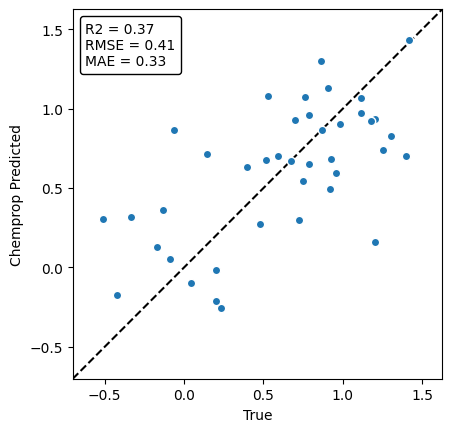

2023-06-12 15:31:32 | 2680376168.py | MainProcess | MainThread | 2680376168.<cell line: 12>:12 - INFO -[[0.37166644306039565, 0.4136287776558931, 0.33376732983040575]]
2023-06-12 15:31:32 | 2680376168.py | MainProcess | MainThread | 2680376168.<cell line: 15>:15 - INFO -(1, 3)
2023-06-12 15:31:32 | 2680376168.py | MainProcess | MainThread | 2680376168.<cell line: 16>:16 - INFO -Index(['r2', 'rmse', 'mae'], dtype='object')
2023-06-12 15:31:32 | 2680376168.py | MainProcess | MainThread | 2680376168.<cell line: 18>:18 - INFO -             r2      rmse       mae
count  1.000000  1.000000  1.000000
mean   0.371666  0.413629  0.333767
std         NaN       NaN       NaN
min    0.371666  0.413629  0.333767
25%    0.371666  0.413629  0.333767
50%    0.371666  0.413629  0.333767
75%    0.371666  0.413629  0.333767
max    0.371666  0.413629  0.333767
2023-06-12 15:31:32 | 2680376168.py | MainProcess | MainThread | 2680376168.<cell line: 19>:19 - INFO -target_column:human CL (mL/min/kg)_log10


In [ ]:
logger.info("-------------在40条测试数据上进行测试-------------")
test_metrics_list=[]
test_result_fold= '/data/project/pbpk/data/'
test_file=test_result_fold+'pk_cl_40_test_2023.csv'
logger.info(test_file)
target_column= 'human CL (mL/min/kg)_log10'
smiles_column="SMILES"
# data_name='pk_cl_1215_train_2023_log10_64_100_%s_%s'%(train_param,data_str)
# data_name="pk_cl_1215_train_2023_log10_64_100_rdkit_2d_normalized_2023_06_12_15_14"
metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
test_metrics_list.append(metrics_list)
logger.info(test_metrics_list)
df_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
# data=data.T
logger.info(df_metrics.shape)
logger.info(df_metrics.columns)
# logger.info(df_metrics.head(10))
logger.info(df_metrics.describe())
logger.info("target_column:%s"%target_column)

## rdkit_2d_normalizedrd test

In [ ]:
%%time
from chemprop.utils import StopWatch
def train(dataset_file,data_name,target_column,smiles_column,batch_size=50,epochs=50):
    arguments = [
      '--data_path',dataset_file,
      '--dataset_type', 'regression',
      '--save_dir', "result/"+data_name,
      '--target_columns', target_column,
      '--smiles_column',smiles_column,
      '--loss_function','mse',
     # '--checkpoint_dir','ck_dir',
      '--split_type', 'random', # Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    #   '--split_sizes',[1,0,0],
    #   '--split_sizes', '0.8', '0.1', '0.1',
     # '--separate_test_path',DATASET_PATH+"cl/"+"pk_cl_40_test_2023_v1.csv",
      '--num_folds','5',
      '--epochs', '%s'%epochs,
      '--batch_size','%s'%batch_size,
      '--save_smiles_splits',
      '--gpu','1',
      # '--ensemble_size','5',
     '--metric', 'rmse',
      '--empty_cache',
      '--extra_metrics', 'r2', 'mae',
        '--no_features_scaling',
        '--features_generator','rdkit_2d_normalized',
        '--quiet'
    ]
    
    # split_type: Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    # """Method of splitting the data into train/val/test."""
    # split_sizes: List[float] = None
    # """Split proportions for train/validation/test sets."""
    # split_key_molecule: int = 0
    # """The index of the key molecule used for splitting when multiple molecules are present and constrained split_type is used, like scaffold_balanced or random_with_repeated_smiles.
    #    Note that this index begins with zero for the first molecule."""
    # num_folds: int = 1
    # """Number of folds when performing cross validation."""

    args = chemprop.args.TrainArgs().parse_args(arguments)
    mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)
    logger.info(arguments)
    logger.info("data_name:%s dataset_file:%s target_column:%s"%(data_name,dataset_file,target_column))
    logger.info("mean_score:%s std_score:%s"%(mean_score,std_score))
    train_result="train cross_validate  mean_score:%s std_score:%s"%(mean_score,std_score)
    logger.info(train_result)
    return arguments,train_result

# test_file=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/test_full.csv'
# test_result_fold=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/'
def predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold):
      
    now_time = datetime.datetime.now()
    data_str = now_time.strftime('%Y_%m_%d_%H_%M')
    arguments = [
        '--test_path', test_file,
        '--preds_path', test_result_fold+'test_preds_%s.csv'%data_str,
        '--smiles_column',smiles_column,
        '--checkpoint_dir', "result/"+data_name,
              # '--features_generator','morgan'#'morgan'
        # '--no_features_scaling',
        # '--features_generator','mordred'
                '--no_features_scaling',
        '--features_generator','rdkit_2d_normalized'
    ]
    # logger.info(arguments)
    args = chemprop.args.PredictArgs().parse_args(arguments)
    preds = chemprop.train.make_predictions(args=args)
    result_path=test_file
    df = pd.read_csv(result_path)
    df['preds'] = [x[0] for x in preds]
    df['Y']=df['preds']
    logger.info(df.head(2))
    result_save_file=test_result_fold+f"{data_name}_pred_result_{data_str}.csv"
    logger.info(result_save_file)
    df.reset_index(inplace=True)
    df = df.drop(columns=df.filter(regex='Unnamed').columns)
    df.to_csv(result_save_file,index=False)
    metrics_list=plot_parity(df[target_column], df.preds)
    return metrics_list,result_save_file
logger.info("初始化完毕")
train_param="rdkit_2d_normalized"

import datetime
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
dataset_dir= DATASET_PATH+"cl/"
 
dataset_name='pk_cl_1215_train_2023_v1.csv'
dataset_file=dataset_dir+dataset_name
logger.info(dataset_dir+dataset_name)
smiles_column='SMILES'
target_column= 'human CL (mL/min/kg)_log10'
# target_column= 'human CL (mL/min/kg)_log2'
# target_column= 'Y'
data_name='pk_cl_1215_%s_%s'%(train_param,data_str)
arguments,train_result=train(dataset_file,data_name,target_column,smiles_column,batch_size=128,epochs=1)
test_metrics_list=[]
for i in  range(0, 5, 1):
    test_result_fold=+f'result/{data_name}/fold_%s/'%i
    test_file=test_result_fold+'test_full.csv'
    logger.info(test_file)
    metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
    test_metrics_list.append(metrics_list)
logger.info(test_metrics_list)
df_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
logger.info("5-fold test predict")
logger.info(df_metrics.shape)
logger.info(df_metrics.columns)
# logger.info(df_metrics.head(10))
logger.info(df_metrics.describe())
logger.info("target_column:%s"%target_column)
logger.info("model data_name:%s"%data_name)
logger.info("-------------在40条测试数据上进行测试-------------")
test_metrics_list=[]
test_result_fold= '/data/project/pbpk/data/'
test_file=test_result_fold+'pk_cl_40_test_2023_v1.csv'
logger.info("---test_file:%s---"%test_file)
# data_name='pk_cl_1215_train_2023_log10_64_100_%s_%s'%(train_param,data_str)
# data_name="pk_cl_1215_train_2023_log10_64_100_rdkit_2d_normalized_2023_06_12_15_14"
metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
test_metrics_list.append(metrics_list)

df_test_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
# data=data.T
logger.info(df_test_metrics.shape)
logger.info(df_test_metrics.columns)
metric_name=['r2', 'rmse','mae']

stopwatch.stop('===cl train model: [ %s ]  ==='%data_name)
logger.info("train args:%s,train metrics:%s"%(arguments,train_result))
logger.info("5-fold metrics:%s"%df_metrics.describe())
logger.info("\n[model: %s testset metrics: %s ]"%(data_name,dict(zip(metric_name, metrics_list))))


2023-07-14 13:48:30 | <timed exec> | MainProcess | MainThread | <timed exec>.<module>:79 - INFO -初始化完毕
2023-07-14 13:48:30 | <timed exec> | MainProcess | MainThread | <timed exec>.<module>:89 - INFO -/data/project/pbpk/pk-model/data/cl/pk_cl_1215_train_2023_v1.csv
1215it [00:00, 163671.61it/s]
 33%|███▎      | 403/1215 [00:00<00:00, 2147.34it/s]

2023-07-14 17:03:04 | 1665750073.py | MainProcess | MainThread | 1665750073.<cell line: 1>:1 - INFO --------------在40条测试数据上进行测试-------------
2023-07-14 17:03:04 | 1665750073.py | MainProcess | MainThread | 1665750073.<cell line: 5>:5 - INFO ----test_file:/data/project/pbpk/data/pk_cl_40_test_2023_v1.csv---


Loading training args
Setting molecule featurization parameters to default.
Loading data


40it [00:00, 137180.83it/s]
100%|██████████| 40/40 [00:05<00:00,  7.01it/s]


MoleculeDataset 计算完毕 记录数: 40
Validating SMILES
Test size = 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda



 20%|██        | 1/5 [00:04<00:19,  4.78s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda



 40%|████      | 2/5 [00:05<00:07,  2.45s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda



 60%|██████    | 3/5 [00:06<00:03,  1.72s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda



 80%|████████  | 4/5 [00:07<00:01,  1.33s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda



100%|██████████| 5/5 [00:07<00:00,  1.57s/it]
2023-07-14 17:03:19 | <timed exec> | MainProcess | MainThread | <timed exec>.predict:68 - INFO -   Unnamed: 0                                SMILES           Name      MW  \
0          19                    CC(=O)Nc1ccc(O)cc1  Acetaminophen  151.16   
1          49  Cc1nnc2CN=C(c3ccccc3)c4cc(Cl)ccc4n12     Alprazolam  308.76   

   HBA  HBD  TPSA_NO  RotBondCount moka_ionState7.4  MoKa.LogP  MoKa.LogD7.4  \
0    3    2     49.3             1          neutral       0.76          0.76   
1    4    0     43.1             1          neutral       2.00          1.90   

          Y  human CL (mL/min/kg)_test                           SMILES_test  \
0  0.398505                       5.00                    CC(=O)Nc1ccc(O)cc1   
1  0.237666                       0.74  Cc1nnc2CN=C(c3ccccc3)c4cc(Cl)ccc4n12   

   human CL (mL/min/kg)  human CL (mL/min/kg)_log2  \
0                  5.00                   2.321928   
1                  0.74         

Saving predictions to /data/project/pbpk/data/test_preds_2023_07_14_17_03.csv
Elapsed time = 0:00:14


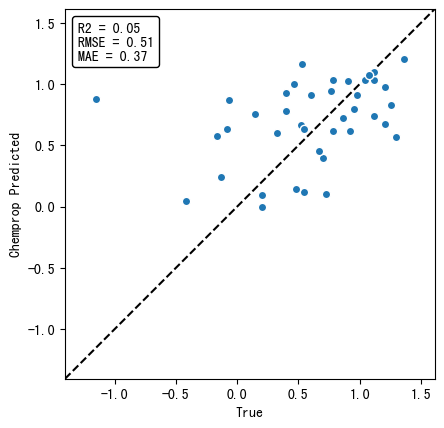

2023-07-14 17:03:19 | 1665750073.py | MainProcess | MainThread | 1665750073.<cell line: 13>:13 - INFO -(1, 3)
2023-07-14 17:03:19 | 1665750073.py | MainProcess | MainThread | 1665750073.<cell line: 14>:14 - INFO -Index(['r2', 'rmse', 'mae'], dtype='object')


NameError: name 'stopwatch' is not defined

In [4]:
logger.info("-------------在40条测试数据上进行测试-------------")
test_metrics_list=[]
test_result_fold= '/data/project/pbpk/data/'
test_file=test_result_fold+'pk_cl_40_test_2023_v1.csv'
logger.info("---test_file:%s---"%test_file)
# data_name='pk_cl_1215_train_2023_log10_64_100_%s_%s'%(train_param,data_str)
# data_name="pk_cl_1215_train_2023_log10_64_100_rdkit_2d_normalized_2023_06_12_15_14"
metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
test_metrics_list.append(metrics_list)

df_test_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
# data=data.T
logger.info(df_test_metrics.shape)
logger.info(df_test_metrics.columns)
metric_name=['r2', 'rmse','mae']

stopwatch.stop('===cl train model: [ %s ]  ==='%data_name)
logger.info("train args:%s,train metrics:%s"%(arguments,train_result))
logger.info("5-fold metrics:%s"%df_metrics.describe())
logger.info("\n[model: %s testset metrics: %s ]"%(data_name,dict(zip(metric_name, metrics_list))))


## nofeature

In [ ]:
%%time

def train(dataset_file,data_name,target_column,smiles_column,batch_size=50,epochs=50):
    arguments = [
      '--data_path',dataset_file,
      '--dataset_type', 'regression',
      '--save_dir', "result/"+data_name,
      '--target_columns', target_column,
      '--smiles_column',smiles_column,
      '--loss_function','mse',
     # '--checkpoint_dir','ck_dir',
      '--split_type', 'random', # Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    #   '--split_sizes',[1,0,0],
    #   '--split_sizes', '0.8', '0.1', '0.1',
     # '--separate_test_path',DATASET_PATH+"cl/"+"pk_cl_40_test_2023_v1.csv",
      '--num_folds','5',
      '--epochs', '%s'%epochs,
      '--batch_size','%s'%batch_size,
      '--save_smiles_splits',
      '--gpu','1',
      # '--ensemble_size','5',
     '--metric', 'rmse',
      '--empty_cache',
      '--extra_metrics', 'r2', 'mae',
        # '--no_features_scaling',
        # '--features_generator','rdkit_2d_normalized',
        '--quiet'
    ]
    
    # split_type: Literal['random', 'scaffold_balanced', 'predetermined', 'crossval', 'cv', 'cv-no-test', 'index_predetermined', 'random_with_repeated_smiles'] = 'random'
    # """Method of splitting the data into train/val/test."""
    # split_sizes: List[float] = None
    # """Split proportions for train/validation/test sets."""
    # split_key_molecule: int = 0
    # """The index of the key molecule used for splitting when multiple molecules are present and constrained split_type is used, like scaffold_balanced or random_with_repeated_smiles.
    #    Note that this index begins with zero for the first molecule."""
    # num_folds: int = 1
    # """Number of folds when performing cross validation."""

    args = chemprop.args.TrainArgs().parse_args(arguments)
    mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)
    logger.info(arguments)
    logger.info("data_name:%s dataset_file:%s target_column:%s"%(data_name,dataset_file,target_column))
    logger.info("mean_score:%s std_score:%s"%(mean_score,std_score))
    train_result="train cross_validate  mean_score:%s std_score:%s"%(mean_score,std_score)
    logger.info(train_result)
    return arguments,train_result
# test_file=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/test_full.csv'
# test_result_fold=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/'
def predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold):
      
    now_time = datetime.datetime.now()
    data_str = now_time.strftime('%Y_%m_%d_%H_%M')
    arguments = [
        '--test_path', test_file,
        '--preds_path', test_result_fold+'test_preds_%s.csv'%data_str,
        '--smiles_column',smiles_column,
        '--checkpoint_dir', "result/"+data_name
              # '--features_generator','morgan'#'morgan'
        # '--no_features_scaling',
        # '--features_generator','mordred'
        #         '--no_features_scaling',
        # '--features_generator','rdkit_2d_normalized'
    ]
    # logger.info(arguments)
    args = chemprop.args.PredictArgs().parse_args(arguments)
    preds = chemprop.train.make_predictions(args=args)
    result_path=test_file
    df = pd.read_csv(result_path)
    df['preds'] = [x[0] for x in preds]
    df['Y']=df['preds']
    logger.info(df.head(2))
    result_save_file=test_result_fold+f"{data_name}_pred_result_{data_str}.csv"
    logger.info(result_save_file)
    df.reset_index(inplace=True)
    df = df.drop(columns=df.filter(regex='Unnamed').columns)
    df.to_csv(result_save_file,index=False)
    metrics_list=plot_parity(df[target_column], df.preds)
    return metrics_list,result_save_file
logger.info("初始化完毕")
train_param=""

import datetime
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
dataset_dir= DATASET_PATH+"cl/"
 
dataset_name='pk_cl_1215_train_2023_v1.csv'
dataset_file=dataset_dir+dataset_name
logger.info(dataset_dir+dataset_name)
smiles_column='SMILES'
target_column= 'human CL (mL/min/kg)_log10'
# target_column= 'human CL (mL/min/kg)_log2'
# target_column= 'Y'
data_name='pk_cl_1215_%s_%s'%(train_param,data_str)
arguments,train_result=train(dataset_file,data_name,target_column,smiles_column,batch_size=32,epochs=50)
test_metrics_list=[]
for i in  range(0, 5, 1):
    test_result_fold=+f'result/{data_name}/fold_%s/'%i
    test_file=test_result_fold+'test_full.csv'
    logger.info(test_file)
    metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
    test_metrics_list.append(metrics_list)
logger.info(test_metrics_list)
df_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
logger.info("5-fold test predict")
logger.info(df_metrics.shape)
logger.info(df_metrics.columns)
# logger.info(df_metrics.head(10))
logger.info(df_metrics.describe())
logger.info("target_column:%s"%target_column)
logger.info("model data_name:%s"%data_name)
logger.info("-------------在40条测试数据上进行测试-------------")
test_metrics_list=[]
test_result_fold= '/data/project/pbpk/data/'
test_file=test_result_fold+'pk_cl_40_test_2023_v1.csv'
logger.info("---test_file:%s---"%test_file)
# data_name='pk_cl_1215_train_2023_log10_64_100_%s_%s'%(train_param,data_str)
# data_name="pk_cl_1215_train_2023_log10_64_100_rdkit_2d_normalized_2023_06_12_15_14"
metrics_list,result_file=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
test_metrics_list.append(metrics_list)

df_test_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
# data=data.T
logger.info(df_test_metrics.shape)
logger.info(df_test_metrics.columns)
metric_name=['r2', 'rmse','mae']

stopwatch.stop('===cl train model: [ %s ]  ==='%data_name)
logger.info("train args:%s,train metrics:%s"%(arguments,train_result))
logger.info("5-fold metrics:%s"%df_metrics.describe())
logger.info("\n[model: %s testset metrics: %s ]"%(data_name,dict(zip(metric_name, metrics_list))))


# Caco2 train

In [ ]:
dataset_dir= '/data/project/pbpk/data/'
dataset_name='caco2_train_set_6083.csv'
dataset_file=dataset_dir+dataset_name
!cat $dataset_file|head -n 2
df_data=pd.read_csv(dataset_file)
logger.info(df_data.columns)
logger.info(df_data.shape)
logger.info(df_data.head(2))

In [ ]:
%%time
import datetime
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
dataset_dir= '/data/project/pbpk/data/'
dataset_name='caco2_train_set_6083.csv'
dataset_file=dataset_dir+dataset_name
logger.info(dataset_dir+dataset_name)
smiles_column='SMILES'
# target_column= 'human CL (mL/min/kg)_log10'
target_column= 'caco2_log10'
# target_column= 'Y'
data_name='caco2_log10_%s_%s'%(train_param,data_str)
logger.info("data_name:%s"%data_name)

train(dataset_file,data_name,target_column,smiles_column,batch_size=64,epochs=200)
# test_file=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/test_full.csv'
# test_result_fold=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/'
# predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
test_metrics_list=[]
for i in  range(0, 5, 1):
  test_result_fold=f'/data/project/pbpk/chemprop/result/{data_name}/fold_%s/'%i
  test_file=test_result_fold+'test_full.csv'
  logger.info(test_file)
  metrics_list=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
  test_metrics_list.append(metrics_list)
logger.info(test_metrics_list)
df_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
# data=data.T
logger.info(df_metrics.shape)
logger.info(df_metrics.columns)
# logger.info(df_metrics.head(10))
logger.info(df_metrics.describe())
logger.info("target_column:%s"%target_column)

In [ ]:
%%time
dataset_dir= '/data/project/pbpk/data/'
dataset_name='caco2_test_set_252.csv'
dataset_file=dataset_dir+dataset_name
logger.info(dataset_dir+dataset_name)
smiles_column='SMILES'
target_column= 'caco2_log10'
data_name='caco2_log10_%s_%s'%(train_param,data_str)
# train(dataset_file,data_name,target_column,smiles_column)
# test_file=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/test_full.csv'
test_file=dataset_dir+'caco2_test_set_252.csv'
test_result_fold=f'/data/project/pbpk/chemprop/result/{data_name}'
predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)

NameError: name 'logger' is not defined

# Fup train

In [4]:
dataset_dir= '/data/project/pbpk/data/'
dataset_name='fup_data_human_2668.csv'
dataset_file=dataset_dir+dataset_name
# !cat $dataset_file|head -n 2
df_data=pd.read_csv(dataset_file)
logger.info(df_data.columns)
logger.info(df_data.shape)
logger.info(df_data.head(2))

2023-08-08 10:27:15 | 2189002909.py | MainProcess | MainThread | 2189002909.<cell line: 6>:6 - INFO -Index(['chembl_id', 'Name', 'Type', 'Max Phase', 'Molecular Weight', 'Targets',
       'Bioactivities', 'AlogP', 'Polar Surface Area', 'HBA', 'HBD',
       '#RO5 Violations', '#Rotatable Bonds', 'Passes Ro3', 'QED Weighted',
       'CX Acidic pKa', 'CX Basic pKa', 'CX LogP', 'CX LogD', 'Aromatic Rings',
       'Structure Type', 'Inorganic Flag', 'Heavy Atoms', 'HBA (Lipinski)',
       'HBD (Lipinski)', '#RO5 Violations (Lipinski)',
       'Molecular Weight (Monoisotopic)', 'Molecular Species',
       'Molecular Formula', 'Smiles', 'Inchi Key', 'fup', 'standard_inchi',
       'canonical_smiles', 'Formula', 'MolWeight', 'SMILES', 'SMILES_STANDARD',
       'fup_log10', 'fup_log2', 'fup_log'],
      dtype='object')
2023-08-08 10:27:15 | 2189002909.py | MainProcess | MainThread | 2189002909.<cell line: 7>:7 - INFO -(2668, 41)
2023-08-08 10:27:15 | 2189002909.py | MainProcess | MainThread | 2

In [5]:
%%time
dataset_dir= '/data/project/pbpk/data/'
dataset_name='fup_data_human_2668.csv'
dataset_file=dataset_dir+dataset_name
logger.info(dataset_dir+dataset_name)
smiles_column='SMILES'
now_time = datetime.datetime.now()
data_str = now_time.strftime('%Y_%m_%d_%H_%M')
target_column= 'fup_log10'
data_name=target_column+"_%s_%s"%(train_param,data_str)
logger.info(data_name)
batch_size=32
epochs=100
train(dataset_file,data_name,target_column,smiles_column,batch_size=batch_size,epochs=epochs)

logger.info("---------train finish!--------")
test_metrics_list=[]
for i in  range(0, 5, 1):
  test_result_fold=f'/data/project/pbpk/chemprop/result/{data_name}/fold_%s/'%i
  test_file=test_result_fold+'test_full.csv'
  logger.info(test_file)
  metrics_list=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold,)
  test_metrics_list.append(metrics_list)
logger.info(test_metrics_list)
df_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
# data=data.T
logger.info(df_metrics.shape)
logger.info(df_metrics.columns)
# logger.info(df_metrics.head(10))
logger.info(df_metrics.describe())
logger.info("target_column:%s"%target_column)
logger.info(f"batch_size={batch_size},epochs={epochs}")

2023-08-08 10:27:20 | <timed exec> | MainProcess | MainThread | <timed exec>.<module>:4 - INFO -/data/project/pbpk/data/fup_data_human_2668.csv
2023-08-08 10:27:20 | <timed exec> | MainProcess | MainThread | <timed exec>.<module>:10 - INFO -fup_log10_padel_2023_08_08_10_27
2668it [00:00, 107730.55it/s]
 41%|████      | 1088/2668 [08:00<11:38,  2.26it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
%%time
%load_ext autoreload
%autoreload 2
import pandas as pd
pd.set_option('max_colwidth',200)
pd.set_option('display.width',200)
pd.set_option('display.max_columns',200)
import os
# Datasets
from tdc.single_pred import ADME

 
# General use 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

#Save and load models
import joblib
import pickle

#Metrics 
import sklearn.metrics as metrics
from sklearn.feature_selection import mutual_info_regression

# RDkit
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
 
test_data_path="/data/project/pbpk/data/test/drug_test_dataset_40.csv"
test_data = pd.read_csv(test_data_path, header=0)
print(test_data.columns)
print(test_data.shape)
# print(test_data.head(5))
print(test_data.describe())
test_data["human CL (mL/min/kg)"]= test_data["in vivo CL_(L/hr/kg)_Human"].apply(lambda x: x*1000/60) #'human CL (mL/min/kg)_log10' (L/hr/kg)
test_data[["fup_log2", "cl_log2"]] = np.log2(test_data[["fup_Human","human CL (mL/min/kg)"]])
test_data[["fup_log10", "cl_log10"]] = np.log10(test_data[["fup_Human","human CL (mL/min/kg)"]])
test_data.to_csv("/data/project/pbpk/data/test/drug_test_dataset_%s.csv"%test_data.shape[0])
print(test_data[["cl_log10","in vivo CL_(L/hr/kg)_Human","human CL (mL/min/kg)"]].head(5))
print(test_data.columns)
smiles_list = test_data['SMILES'].to_list()
print(smiles_list)


# dataset_dir= '/data/project/pbpk/data/'
# dataset_name='fup_data_human_2668.csv'
# dataset_file=dataset_dir+dataset_name
# logger.info(dataset_dir+dataset_name)
# smiles_column='SMILES'
# target_column= 'fup_log10'
# data_name='fup_log10'

# train(dataset_file,data_name,target_column,smiles_column,batch_size=128,epochs=20)
# test_file=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/test_full.csv'
# test_result_fold=f'/data/project/pbpk/chemprop/result/{data_name}/fold_0/'
# predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
test_file=test_data_path
test_metrics_list=[]

test_result_fold=f"/data/project/pbpk/chemprop/result/{data_name}"
metrics_list=predict(dataset_file,data_name,target_column,smiles_column,test_file,test_result_fold)
test_metrics_list.append(metrics_list)
logger.info(test_metrics_list)
df_metrics=pd.DataFrame(test_metrics_list,columns=['r2', 'rmse', 'mae'])#这时原列表中的每个元素对应一条数据
# data=data.T
logger.info(df_metrics.shape)
logger.info(df_metrics.columns)
# logger.info(df_metrics.head(10))
logger.info(df_metrics.describe())
logger.info("target_column:%s"%target_column)
logger.info("batch_size=50,epochs=50")
